/tmp/ipykernel_13213/1085605864.py:13: RuntimeWarning: invalid value encountered in divide
  norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x79cee98faa20>
Traceback (most recent call last):
  File "/home/alejandro/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/alejandro/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alejandro/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/alejandro/anaconda3/lib/python3.11/site-

[[ 59  29 220]
 [ 73  18 238]
 [ 82  14 251]
 [  0   0   0]]


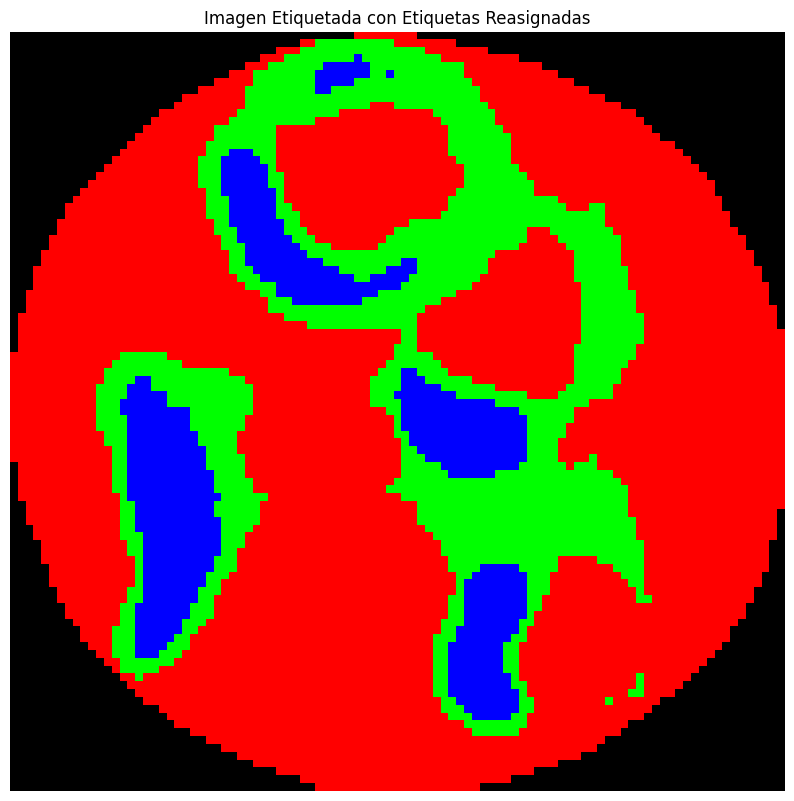

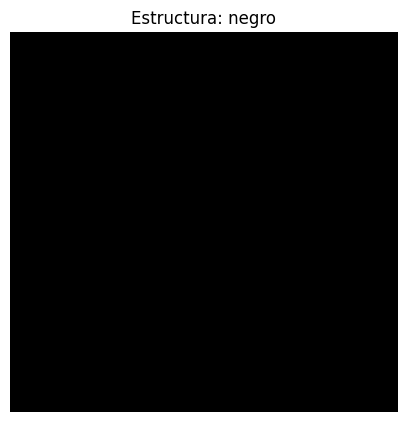

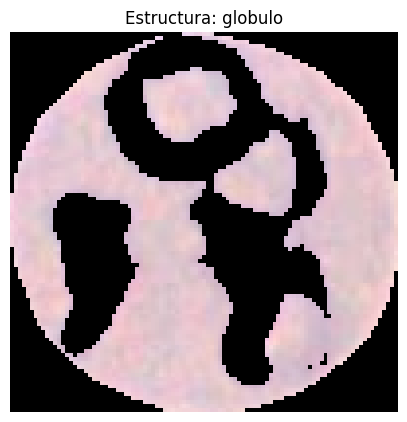

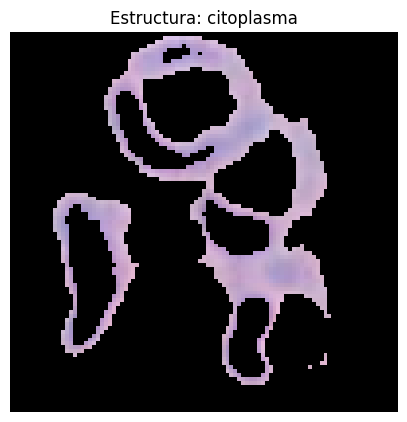

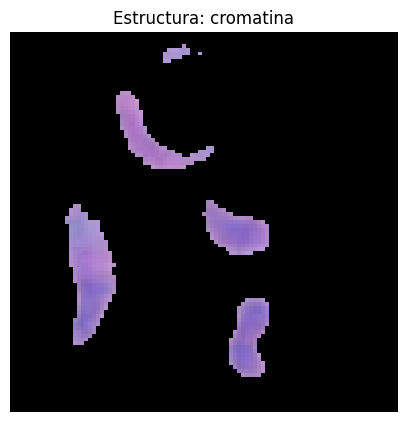

Conteo de píxeles por grupo con etiquetas reasignadas:
globulo: 5099 píxeles
negro: 2000 píxeles
citoplasma: 1725 píxeles
cromatina: 779 píxeles


In [47]:
from collections import defaultdict
from sklearn.metrics import pairwise_distances_argmin_min
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color as skcolor
import pandas as pd

# Definir la función de normalización de imagen
def normalize_img(img: np.ndarray, rimg: np.ndarray) -> np.ndarray:
    norm_img = np.zeros_like(img, dtype=np.float64)
    for c in range(3):
        norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
        norm_img[:, :, c] = np.nan_to_num(norm_img[:, :, c], nan=0)
    norm_img = np.clip(norm_img, 0, 1)
    return norm_img

def CilToCart(arr):
    
    z = arr[:,0]
    rho = arr[:,1]
    phi = arr[:,2]
    x = rho * np.cos( phi )
    y = rho * np.sin( phi )
    arr[:,1] = x
    arr[:,2] = y
    return arr   

# Ajustar las rutas de las imágenes
img_path = 'img/2023-08-08 19.38.42-1_seg_000.png'
rimg_path = 'img/2023-08-08 19.38.42-1_seg_000_ref.png'

# Leer las imágenes
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
rimg = cv2.cvtColor(cv2.imread(rimg_path), cv2.COLOR_BGR2RGB)

# Normalizar la imagen
norm_img = normalize_img(img, rimg)

# Convertir la imagen normalizada a espacio de color LAB y LCH
lab_image = skcolor.rgb2lab(norm_img)
lch_image = skcolor.lab2lch(lab_image)

# Convertir LCH a coordenadas cartesianas
lch_image_cartesian = CilToCart(lch_image.copy().reshape(-1, 3)).reshape(lch_image.shape)

# Crear la imagen LABCH (L, a, b, C, H)
labch_image = np.stack((lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2], lch_image[:, :, 1], lch_image[:, :, 2]), axis=-1)

# Redimensionar la imagen para el clustering
original_shape = lab_image.shape
lab_image_reshaped = lab_image.reshape((-1, 3))
lch_image_reshaped = lch_image.reshape((-1, 3))

lab_image_reshaped = np.float32(lab_image_reshaped)
lch_image_reshaped = np.float32(lch_image_reshaped)

# Aplicar clustering k-means
stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)
number_of_attempts = 30
centroid_initialization_strategy = cv2.KMEANS_RANDOM_CENTERS
K = 4
_, labels, centers = cv2.kmeans(lab_image_reshaped, K, None, stop_criteria, number_of_attempts, centroid_initialization_strategy)

centers = np.uint8(centers)

# Reconstruir la imagen segmentada
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(original_shape)

# Asignar etiquetas a los centros
label_names = ["negro", "globulo", "citoplasma", "cromatina"]

# Calcular la distancia de cada píxel a los centros
closest_centers, distances = pairwise_distances_argmin_min(segmented_image.reshape(-1, 3), centers)

# Reestructurar la matriz closest_centers para que coincida con la imagen original
closest_centers = closest_centers.reshape(segmented_image.shape[:2])

# Crear una imagen para almacenar las etiquetas
label_image = np.empty(segmented_image.shape[:2], dtype=object)

# Asignar etiquetas basado en la proximidad al centroide correspondiente
for i, label in enumerate(label_names):
    mask = closest_centers == i
    label_image[mask] = label

print(centers)

# Contar la cantidad de píxeles en cada grupo
pixel_counts = {label: np.sum(label_image == label) for label in label_names}

# Ordenar los grupos por cantidad de píxeles de mayor a menor
sorted_labels = sorted(pixel_counts, key=pixel_counts.get, reverse=True)

# Reasignar etiquetas según el nuevo orden
new_label_names = {
    sorted_labels[0]: "globulo",
    sorted_labels[1]: "negro",
    sorted_labels[2]: "citoplasma",
    sorted_labels[3]: "cromatina"
}

# Actualizar los colores según la nueva asignación
new_label_colors = {
    "negro": [0, 0, 0],
    "globulo": [255, 0, 0],
    "citoplasma": [0, 255, 0],
    "cromatina": [0, 0, 255],
}

# Crear una nueva imagen con las etiquetas reasignadas
reassigned_label_image = np.empty_like(label_image, dtype=object)

for old_label, new_label in new_label_names.items():
    reassigned_label_image[label_image == old_label] = new_label

# Crear la imagen con los nuevos colores
reassigned_colored_image = np.zeros((*reassigned_label_image.shape, 3), dtype=np.uint8)

for label, color in new_label_colors.items():
    reassigned_colored_image[reassigned_label_image == label] = color

# Mostrar la imagen corregida con los nuevos colores y etiquetas
plt.figure(figsize=(10, 10))
plt.imshow(reassigned_colored_image)
plt.title("Imagen Etiquetada con Etiquetas Reasignadas")
plt.axis('off')
plt.show()

# Graficar cada grupo por separado con las nuevas etiquetas y colores
for label in ["negro", "globulo", "citoplasma", "cromatina"]:
    mask = reassigned_label_image == label
    group_image = np.zeros_like(img)
    group_image[mask] = img[mask]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(group_image)
    plt.title(f"Estructura: {label}")
    plt.axis('off')
    plt.show()

# Crear un DataFrame para almacenar los valores RGB originales y sus etiquetas reasignadas
data = []
for i in range(reassigned_label_image.shape[0]):
    for j in range(reassigned_label_image.shape[1]):
        rgb_value = list(img[i, j])
        labch_value = list(labch_image[i, j])
        label = reassigned_label_image[i, j]
        data.append([rgb_value,labch_value,label])

df = pd.DataFrame(data, columns=["RGB","LABCH","Etiqueta"])

# Mostrar una vista previa del DataFrame
df.head()

# Contar y mostrar los pixeles por grupo con las nuevas etiquetas
new_pixel_counts = {new_label_names[old_label]: pixel_counts[old_label] for old_label in label_names}
new_pixel_counts = dict(sorted(new_pixel_counts.items(), key=lambda item: item[1], reverse=True))
print("Conteo de píxeles por grupo con etiquetas reasignadas:")
for label, count in new_pixel_counts.items():
    print(f"{label}: {count} píxeles")


In [50]:
df.iloc[44:100,:]

,RGB,LABCH,Etiqueta
44,"[231, 211, 236]","[87.27877510315894, 13.916538279435397, -14.65...",globulo
45,"[237, 215, 238]","[88.805496966016, 14.173380476512953, -13.4215...",globulo
46,"[235, 211, 233]","[87.51936834870294, 14.643729744773848, -12.60...",globulo
47,"[229, 204, 225]","[85.0729860773213, 14.795038169039765, -11.884...",globulo
48,"[234, 205, 225]","[85.74435419616259, 15.94184895693973, -10.837...",globulo
49,"[242, 215, 232]","[89.0441760111795, 14.6825972175052, -9.720254...",globulo
50,"[240, 220, 232]","[90.08384353972077, 11.396334293283184, -8.195...",globulo
51,"[229, 212, 222]","[86.93381425640217, 9.99449077016351, -7.45532...",globulo
52,"[0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0]",negro
53,"[0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0]",negro
